# 자치구 연령대별 제과점 개수 분석

## 데이터 출처
- 서울시 제과점(업종=빵/도넛) : 공공데이터포털
- 서울시 자치구별 인구 : 서울연린데이터광장

## 분성 방법 : 피어슨 상관계수
## 분석 목표 : 어느 자치구에 제과점을 차리는 것이 제일 유리할까?

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"

# 파일 경로 지정
file_path = r"D:\SEOUL\서울시 음식점.xlsx"

# 엑셀 파일 읽기
bread = pd.read_excel(file_path)

# 데이터 확인 (상위 5행 출력)
print(bread.head())

           상호명 상권업종대분류명 상권업종중분류명      상권업종소분류명  시군구명
0          까페인       음식    비알코올             카페   금천구
1         남원통닭       음식    기타 간이            치킨  동대문구
2          씨에프       음식       주점         요리 주점   성북구
3  시로이돈까스NC강서점       음식       일식  일식 카레/돈가스/덮밥   강서구
4         루아키친       음식       한식        백반/한정식   강남구


In [21]:
print(bread.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136881 entries, 0 to 136880
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   상호명       136881 non-null  object
 1   상권업종대분류명  136881 non-null  object
 2   상권업종중분류명  136881 non-null  object
 3   상권업종소분류명  136881 non-null  object
 4   시군구명      136881 non-null  object
dtypes: object(5)
memory usage: 5.2+ MB
None


In [22]:
# 빵/도넛 vs 기타 업종 구분 컬럼 생성
bread['업종구분'] = bread['상권업종소분류명'].apply(lambda x: '빵/도넛' if x == '빵/도넛' else '기타')

# 빵/도넛 여부를 숫자로 표시 (1=빵/도넛, 0=기타)
bread['is_bread'] = bread['상권업종소분류명'].apply(lambda x: 1 if x == '빵/도넛' else 0)

# 전처리 결과 확인
print(bread[['상권업종소분류명', '업종구분', 'is_bread']].head())

       상권업종소분류명 업종구분  is_bread
0            카페   기타         0
1            치킨   기타         0
2         요리 주점   기타         0
3  일식 카레/돈가스/덮밥   기타         0
4        백반/한정식   기타         0


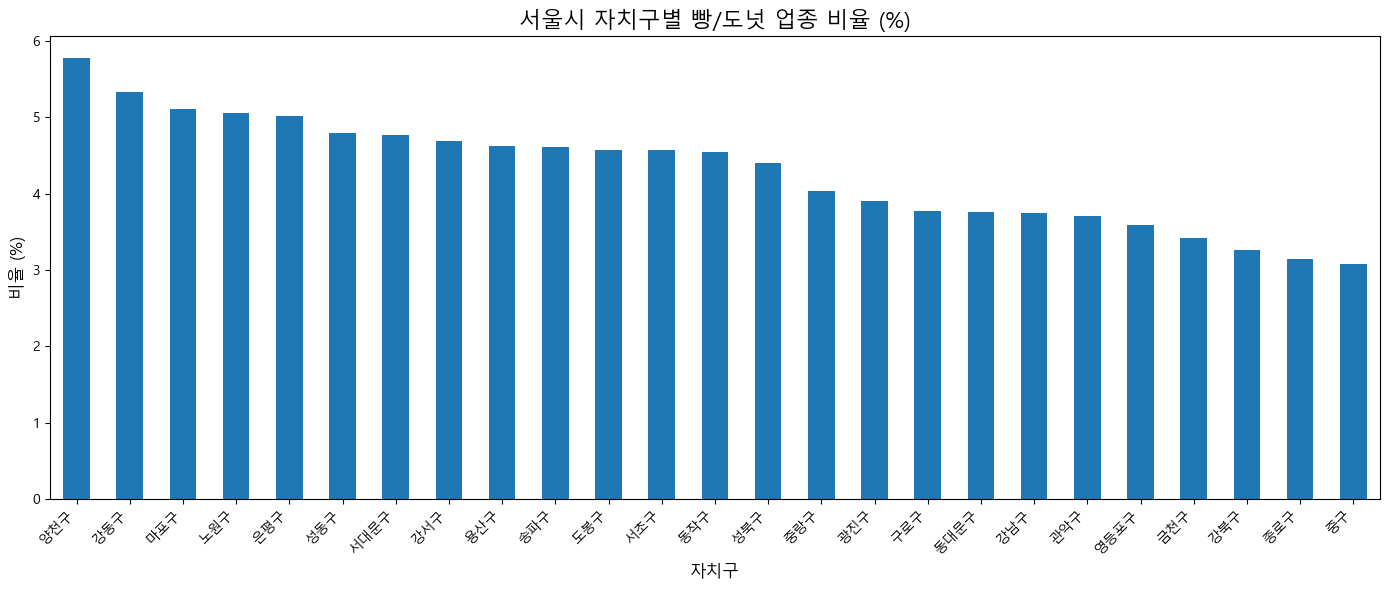

In [23]:
# 3. 자치구별 빵/도넛 비율 계산
district_ratio = bread.groupby('시군구명')['is_bread'].mean() * 100  # 비율(%)로 변환

# 4. 막대그래프 그리기
plt.figure(figsize=(14,6))
district_ratio.sort_values(ascending=False).plot(kind='bar')

plt.title("서울시 자치구별 빵/도넛 업종 비율 (%)", fontsize=16)
plt.xlabel("자치구", fontsize=12)
plt.ylabel("비율 (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [24]:
import numpy as np

In [27]:
# 1) 데이터 불러오기
src_path = r"D:\SEOUL\서울시 음식점.xlsx"
df = pd.read_excel(src_path)

# 2) 기본 전처리: 필요한 컬럼 정리
#   - D열: '상권업종소분류명', E열: '자치구명' 을 사용
#   - 공백/결측 정리
for col in ['상권업종소분류명', '자치구명']:
    if col not in df.columns:
        raise KeyError(f"엑셀에 '{col}' 컬럼이 없습니다. 컬럼명을 확인해주세요.")
    df[col] = df[col].astype(str).str.strip()

# 결측/빈 자치구 제거
df = df[df['자치구명'].notna() & (df['자치구명'].str.len() > 0)]

# 3) 빵/도넛 여부 플래그
df['is_bread'] = (df['상권업종소분류명'] == '빵/도넛').astype(int)

# 4) 자치구별 집계
total = df.groupby('자치구명').size().rename('전체_업체수')
bread_cnt = df.groupby('자치구명')['is_bread'].sum().rename('빵/도넛_업체수')
other_cnt = (total - bread_cnt).rename('기타업종_업체수')

# 5) 비율 계산
#   - 전체 대비: 빵/도넛 / 전체
#   - 기타 대비: 빵/도넛 / 기타 (기타가 0이면 NaN)
ratio_total = (bread_cnt / total * 100).rename('빵/도넛_비율(전체대비,%)')
ratio_other = np.where(other_cnt > 0, bread_cnt / other_cnt * 100, np.nan)
ratio_other = pd.Series(ratio_other, index=bread_cnt.index, name='빵/도넛_비율(기타대비,%)')

# 6) 결과 병합 및 정렬(자치구명 가나다)
result = pd.concat([bread_cnt, other_cnt, total, ratio_total, ratio_other], axis=1).sort_index()

# 7) 엑셀로 저장
out_path = r"D:\SEOUL\자치구별_빵도넛_현황.xlsx"
with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
    result.to_excel(writer, sheet_name='자치구별_요약')

print("저장 완료:", out_path)

저장 완료: D:\SEOUL\자치구별_빵도넛_현황.xlsx


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"

# 파일 경로 지정
file_path = r"D:\SEOUL\자치구 인구별 제과점.xlsx"

# 엑셀 파일 읽기 → DataFrame을 bread 변수에 저장
bread = pd.read_excel(file_path)  # 필요 시 sheet_name="시트명" 추가

# 확인 (처음 5행)
print(bread.head())

   자치구      소계   0~4세   5~9세  10~14세  15~19세  20~24세  25~29세  30~34세  35~39세  \
0  강남구  531739  11413  19972   29652   29087   25727   36652   41423   37093   
1  강동구  453409  12348  17208   19497   18710   20914   32651   35514   32925   
2  강북구  280273   4225   6411    8360    9763   16666   20962   19147   15490   
3  강서구  548230  12449  16520   19399   20010   26972   47729   53532   41970   
4  관악구  492798   6779   8771   10436   13428   38741   73452   58287   34258   

   ...  60~64세  65~69세  70~74세  75~79세  80~84세  85~89세  90~94세  95세 이상+  제과점수  \
0  ...   32638   30545   22411   17044   10322    4974    1861      522   454   
1  ...   35952   32531   21862   15138    9252    4400    1645      495   266   
2  ...   24843   22375   16196   13502   10093    4683    1281      357   122   
3  ...   41669   38513   25997   18534   11816    6058    2107      625   324   
4  ...   33394   29526   21749   17053   12026    5280    1492      373   210   

         비율  
0  3.745257  
1  5

In [40]:
print(bread.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   자치구      25 non-null     object 
 1   소계       25 non-null     int64  
 2   0~4세     25 non-null     int64  
 3   5~9세     25 non-null     int64  
 4   10~14세   25 non-null     int64  
 5   15~19세   25 non-null     int64  
 6   20~24세   25 non-null     int64  
 7   25~29세   25 non-null     int64  
 8   30~34세   25 non-null     int64  
 9   35~39세   25 non-null     int64  
 10  40~44세   25 non-null     int64  
 11  45~49세   25 non-null     int64  
 12  50~54세   25 non-null     int64  
 13  55~59세   25 non-null     int64  
 14  60~64세   25 non-null     int64  
 15  65~69세   25 non-null     int64  
 16  70~74세   25 non-null     int64  
 17  75~79세   25 non-null     int64  
 18  80~84세   25 non-null     int64  
 19  85~89세   25 non-null     int64  
 20  90~94세   25 non-null     int64  
 21  95세 이상+  25 non-nu

In [37]:
# 2. 분석 대상 컬럼 추출
# A: 자치구 / B: 총 인구수 / C~V: 연령대별 인구수 / W: 제과점수 / X: 음식점 대비 제과점 비율
# C열~X열 추출
cols_to_analyze = bread.columns[2:24].tolist() + [bread.columns[22], bread.columns[23]]
# 위 코드에서 columns[2:24] → C~V, [22] → W, [23] → X

# 3. 선택한 데이터프레임
df_corr = bread[cols_to_analyze]

# 4. 상관계수 계산 (피어슨 상관계수)
corr_matrix = df_corr.corr(method='pearson')

# 5. 결과 확인
print("연령대별 인구수, 제과점수, 제과점 비율 간 상관계수:")
print(corr_matrix)

# 6. 엑셀로 저장 (선택)
out_path = r"D:\SEOUL\자치구_제과점_상관분석.xlsx"
corr_matrix.to_excel(out_path, sheet_name='상관계수')

print("상관계수 분석 결과 저장 완료:", out_path)

연령대별 인구수, 제과점수, 제과점 비율 간 상관계수:
             0~4세      5~9세    10~14세    15~19세    20~24세    25~29세    30~34세  \
0~4세     1.000000  0.951031  0.846971  0.826733  0.494978  0.537086  0.760441   
5~9세     0.951031  1.000000  0.964448  0.941393  0.477869  0.456018  0.670830   
10~14세   0.846971  0.964448  1.000000  0.984719  0.435737  0.380992  0.578469   
15~19세   0.826733  0.941393  0.984719  1.000000  0.543325  0.436469  0.591523   
20~24세   0.494978  0.477869  0.435737  0.543325  1.000000  0.775168  0.600515   
25~29세   0.537086  0.456018  0.380992  0.436469  0.775168  1.000000  0.913119   
30~34세   0.760441  0.670830  0.578469  0.591523  0.600515  0.913119  1.000000   
35~39세   0.936044  0.871154  0.774114  0.764977  0.555558  0.754543  0.934684   
40~44세   0.952165  0.969244  0.927847  0.918068  0.543754  0.624335  0.819449   
45~49세   0.903404  0.965668  0.968523  0.969674  0.540755  0.561772  0.744387   
50~54세   0.896114  0.936764  0.927484  0.950485  0.595848  0.594838  0.757775 

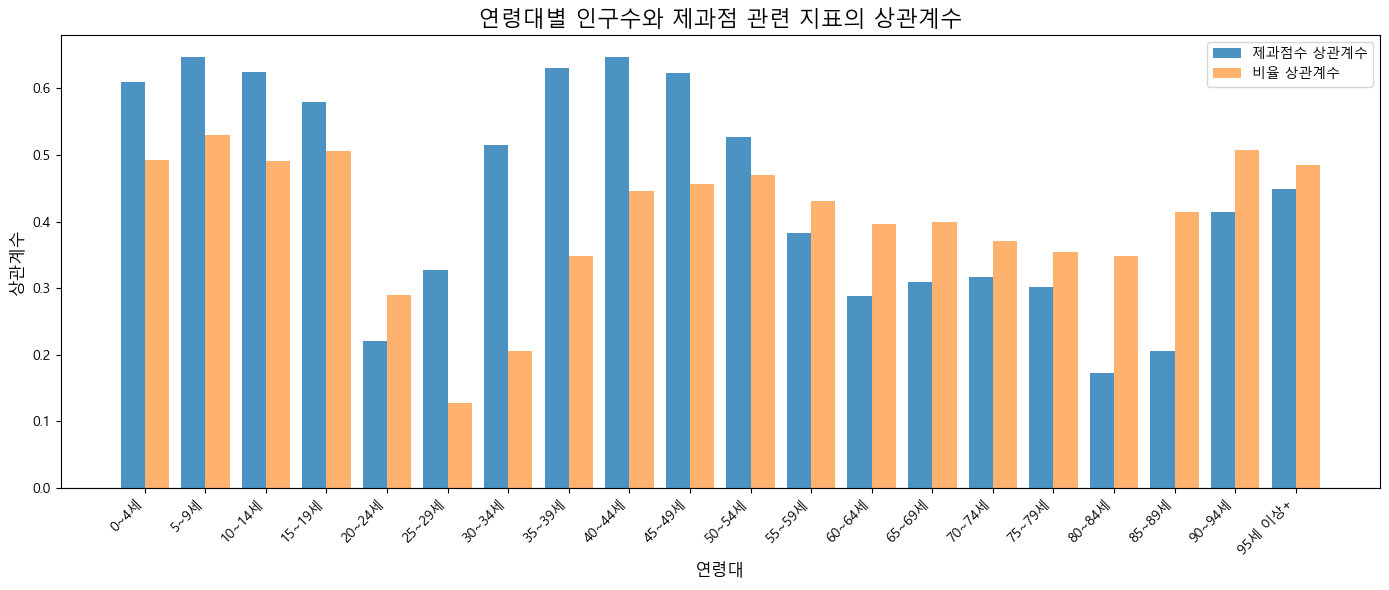

제과점수와 가장 높은 상관: 5~9세 0.6474109526434916
제과점 비율과 가장 높은 상관: 5~9세 0.5297717548258607


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 불러오기
file_path = r"D:\SEOUL\자치구 인구별 제과점.xlsx"
bread = pd.read_excel(file_path)

# 2) 열 지정: C~V(연령대), W(제과점수), X(비율)
age_cols = bread.columns[2:22]   # ✅ C~V (끝 인덱스 22는 포함되지 않으므로 정확히 C~V)
w_col = bread.columns[22]        # W
x_col = bread.columns[23]        # X

# 3) 상관계수 계산
corr_matrix = bread[age_cols.tolist() + [w_col, x_col]].corr()

# 4) 제과점수/비율과의 상관계수(1D Series로 보장)
def ensure_series(colname):
    obj = corr_matrix[colname]
    # 중복 컬럼명으로 DataFrame이 반환되는 경우 첫 열만 사용
    if isinstance(obj, pd.DataFrame):
        obj = obj.iloc[:, 0]
    # age_cols 순서로 정렬 + 1D 보장
    obj = obj.reindex(age_cols).astype(float)
    return obj

corr_with_w = ensure_series(w_col)
corr_with_x = ensure_series(x_col)

# (선택) 디버그: 길이/차원 확인
# print(len(age_cols), corr_with_w.shape, corr_with_x.shape)

# 5) 시각화 (연령대별 두 막대: W와 X)
x = np.arange(len(age_cols))
width = 0.4

plt.figure(figsize=(14,6))
plt.bar(x - width/2, corr_with_w.values, width=width, alpha=0.8, label=f"{w_col} 상관계수")
plt.bar(x + width/2, corr_with_x.values, width=width, alpha=0.6, label=f"{x_col} 상관계수")

plt.axhline(0, linewidth=0.8)
plt.title("연령대별 인구수와 제과점 관련 지표의 상관계수", fontsize=16)
plt.xlabel("연령대", fontsize=12)
plt.ylabel("상관계수", fontsize=12)
plt.xticks(x, age_cols, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# 6) 가장 유의미한(절댓값 최대) 연령대 출력
print("제과점수와 가장 높은 상관:", corr_with_w.abs().idxmax(), corr_with_w.loc[corr_with_w.abs().idxmax()])
print("제과점 비율과 가장 높은 상관:", corr_with_x.abs().idxmax(), corr_with_x.loc[corr_with_x.abs().idxmax()])

저장 완료: D:\SEOUL\자치구별_제과점_예측비교.xlsx


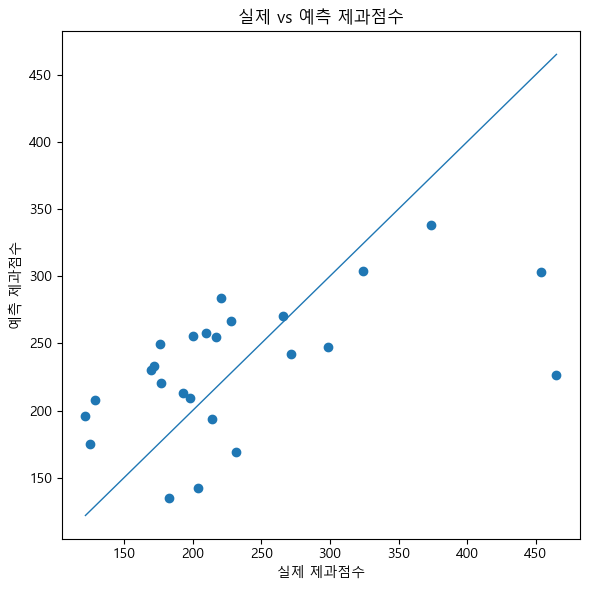

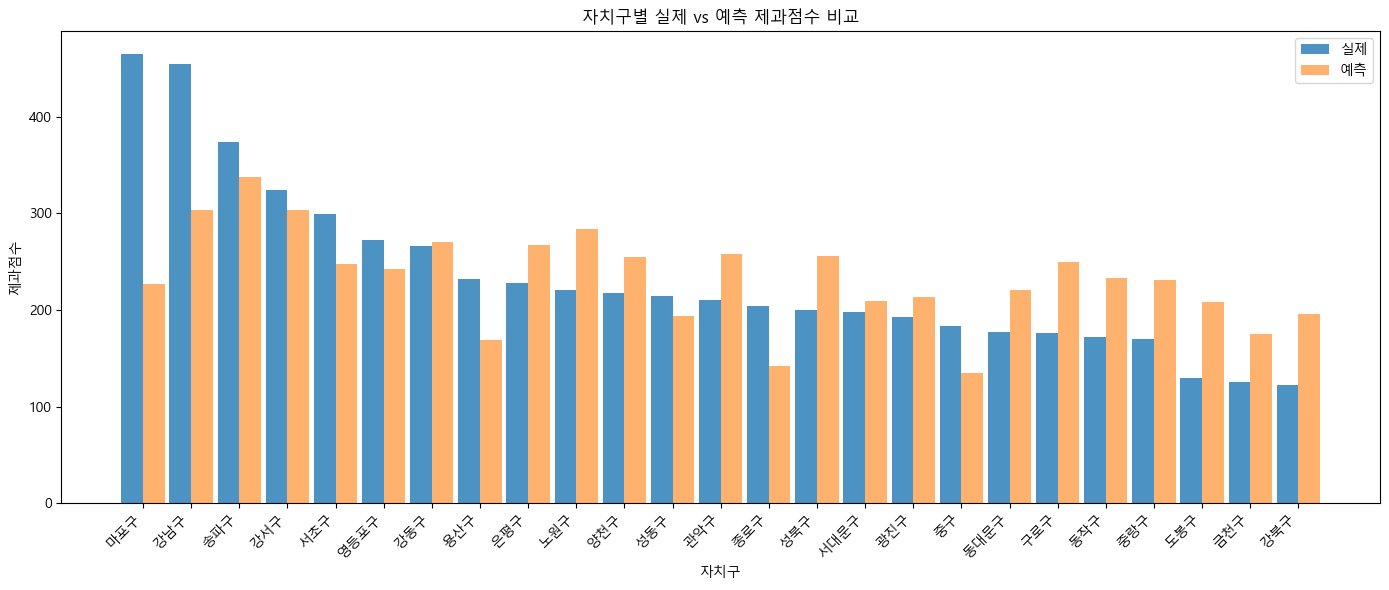


[연령대별 상관계수 및 가중치]
             상관계수  가중치(|corr| 정규화)  부호반영_가중치
5~9세     0.647411         0.073632  0.073632
40~44세   0.647010         0.073586  0.073586
35~39세   0.630337         0.071690  0.071690
10~14세   0.624186         0.070990  0.070990
45~49세   0.622484         0.070797  0.070797
0~4세     0.610097         0.069388  0.069388
15~19세   0.579802         0.065942  0.065942
50~54세   0.527750         0.060022  0.060022
30~34세   0.514727         0.058541  0.058541
95세 이상+  0.448929         0.051058  0.051058
90~94세   0.414152         0.047103  0.047103
55~59세   0.382223         0.043471  0.043471
25~29세   0.327368         0.037232  0.037232
70~74세   0.317360         0.036094  0.036094
65~69세   0.308721         0.035112  0.035112
75~79세   0.302093         0.034358  0.034358
60~64세   0.288083         0.032764  0.032764
20~24세   0.220750         0.025106  0.025106
85~89세   0.206271         0.023460  0.023460
80~84세   0.172799         0.019653  0.019653


In [42]:
df = pd.read_excel(file_path)

# 2) 열 지정: C~V(연령대 인구), W(제과점수)
#    주의: 파이썬 슬라이스의 끝 인덱스는 포함되지 않으므로 C~V는 [2:22], W는 [22]
age_cols = df.columns[2:22]    # C~V
w_col = df.columns[22]         # W: 제과점수

# 3) 숫자형 변환 (문자/결측 처리 방지)
for c in list(age_cols) + [w_col]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=[w_col])  # 타깃 결측은 제거

# 4) 연령대별 인구 vs 제과점수의 상관계수 계산
corr_with_w = df[age_cols].corrwith(df[w_col])  # 1D Series
# 결측(상관 불가) 대비 0으로 대체
corr_with_w = corr_with_w.fillna(0.0)

# 5) 가중치 만들기
#    - 절댓값이 클수록 높은 가중치
#    - 부호(sign)는 상관계수의 방향을 반영 (양/음 영향)
abs_w = corr_with_w.abs()
if abs_w.sum() == 0:
    # 모든 상관이 0이면 동일 가중치 부여
    base_weights = pd.Series(1.0 / len(age_cols), index=age_cols)
else:
    base_weights = abs_w / abs_w.sum()

signed_weights = base_weights * np.sign(corr_with_w)

# 6) 연령대 인구 표준화(Z-score) 후 가중합으로 "적정 점수(스코어)" 생성
Z = (df[age_cols] - df[age_cols].mean()) / df[age_cols].std(ddof=0)
score = (Z * signed_weights).sum(axis=1)

# 7) 스코어 → 제과점수 스케일로 선형 변환(일변량 선형회귀)
#    polyfit으로 a,b 추정: pred = a*score + b
a, b = np.polyfit(score.values, df[w_col].values, deg=1)
df['예측_제과점수'] = a * score + b
df['실제_제과점수'] = df[w_col]
df['오차(실제-예측)'] = df['실제_제과점수'] - df['예측_제과점수']

# 8) 결과 저장(선택)
out_path = r"D:\SEOUL\자치구별_제과점_예측비교.xlsx"
save_cols = [df.columns[0]] + list(age_cols) + ['실제_제과점수', '예측_제과점수', '오차(실제-예측)']
# df.columns[0]이 자치구 구분(A열)이라 가정
df.to_excel(out_path, index=False, columns=save_cols)
print("저장 완료:", out_path)

# 9) 그래프 1: 실제 vs 예측 산점도 (적합도 확인)
plt.figure(figsize=(6,6))
plt.scatter(df['실제_제과점수'], df['예측_제과점수'])
min_val = np.nanmin([df['실제_제과점수'].min(), df['예측_제과점수'].min()])
max_val = np.nanmax([df['실제_제과점수'].max(), df['예측_제과점수'].max()])
plt.plot([min_val, max_val], [min_val, max_val], linewidth=1)  # y=x 기준선
plt.title("실제 vs 예측 제과점수")
plt.xlabel("실제 제과점수")
plt.ylabel("예측 제과점수")
plt.tight_layout()
plt.show()

# 10) 그래프 2: 자치구별 실제/예측 막대 비교
#      자치구(A열, df.columns[0]) 기준 상위 N개만 보거나 전체 표시
district_col = df.columns[0]   # A열: 자치구 구분
# 보기 좋게 실제 값 기준 내림차순 정렬
plot_df = df[[district_col, '실제_제과점수', '예측_제과점수']].sort_values('실제_제과점수', ascending=False)
x = np.arange(len(plot_df))
width = 0.45

plt.figure(figsize=(14,6))
plt.bar(x - width/2, plot_df['실제_제과점수'].values, width=width, alpha=0.8, label='실제')
plt.bar(x + width/2, plot_df['예측_제과점수'].values, width=width, alpha=0.6, label='예측')
plt.xticks(x, plot_df[district_col].astype(str).values, rotation=45, ha='right')
plt.title("자치구별 실제 vs 예측 제과점수 비교")
plt.xlabel("자치구")
plt.ylabel("제과점수")
plt.legend()
plt.tight_layout()
plt.show()

# 11) 참고: 상관 가중치 표 출력
print("\n[연령대별 상관계수 및 가중치]")
print(pd.DataFrame({
    '상관계수': corr_with_w,
    '가중치(|corr| 정규화)': base_weights,
    '부호반영_가중치': signed_weights
}).sort_values('가중치(|corr| 정규화)', ascending=False))

In [43]:
import numpy as np
# 열 지정 (C~V: 연령대 인구, W: 제과점수)
age_cols = df.columns[2:22]
w_col = df.columns[22]

# 숫자형 변환
for c in list(age_cols) + [w_col]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=[w_col])

# 상관계수 기반 가중치
corr_with_w = df[age_cols].corrwith(df[w_col]).fillna(0.0)
abs_w = corr_with_w.abs()
if abs_w.sum() == 0:
    base_weights = pd.Series(1.0 / len(age_cols), index=age_cols)
else:
    base_weights = abs_w / abs_w.sum()
signed_weights = base_weights * np.sign(corr_with_w)

# Z-score 표준화 + 가중합
Z = (df[age_cols] - df[age_cols].mean()) / df[age_cols].std(ddof=0)
score = (Z * signed_weights).sum(axis=1)

# 선형 변환으로 예측값 스케일 조정
a, b = np.polyfit(score.values, df[w_col].values, deg=1)
df['예측_제과점수'] = a * score + b
df['실제_제과점수'] = df[w_col]
df['오차(실제-예측)'] = df['실제_제과점수'] - df['예측_제과점수']

# 자치구별 비교표 생성 (자치구는 A열이라고 가정)
district_col = df.columns[0]
compare_table = df[[district_col, '실제_제과점수', '예측_제과점수', '오차(실제-예측)']]

# 표 출력
print(compare_table)

     자치구  실제_제과점수     예측_제과점수   오차(실제-예측)
0    강남구      454  303.124423  150.875577
1    강동구      266  270.189070   -4.189070
2    강북구      122  196.019318  -74.019318
3    강서구      324  303.659612   20.340388
4    관악구      210  257.951822  -47.951822
5    광진구      193  213.219045  -20.219045
6    구로구      176  249.696951  -73.696951
7    금천구      125  175.339217  -50.339217
8    노원구      221  283.749270  -62.749270
9    도봉구      129  207.734081  -78.734081
10  동대문구      177  220.461012  -43.461012
11   동작구      172  232.889361  -60.889361
12   마포구      465  226.496345  238.503655
13  서대문구      198  209.563440  -11.563440
14   서초구      299  247.644155   51.355845
15   성동구      214  193.729597   20.270403
16   성북구      200  255.565197  -55.565197
17   송파구      374  337.754260   36.245740
18   양천구      217  254.639519  -37.639519
19  영등포구      272  242.181680   29.818320
20   용산구      232  168.965939   63.034061
21   은평구      228  266.703819  -38.703819
22   종로구      204  142.354775   61

# 도봉구에 빵집을 열자